In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from iteration_utilities import first

2024-08-01 22:54:35.968701: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 22:54:35.979914: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 22:54:36.091905: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 22:54:36.213631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 22:54:36.304014: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
batch_size = 16
img_height = 180
img_width = 180

In [3]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [4]:
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_dataset.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Using 5235 files for validation.
['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [5]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names))
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
epochs=10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)


/home/vlad/Documents/Projects/animal_classification/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,930 (15.22 MB)

 Trainable params: 3,989,930 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 86s 65ms/step - accuracy: 0.3105 - loss: 1.9545 - val_accuracy: 0.4306 - val_loss: 1.6539
Epoch 2/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 88s 68ms/step - accuracy: 0.5328 - loss: 1.3903 - val_accuracy: 0.5645 - val_loss: 1.3066
Epoch 3/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 86s 66ms/step - accuracy: 0.5931 - loss: 1.2066 - val_accuracy: 0.5948 - val_loss: 1.2000
Epoch 4/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 88s 67ms/step - accuracy: 0.6319 - loss: 1.1040 - val_accuracy: 0.5996 - val_loss: 1.2270
Epoch 5/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 87s 67ms/step - accuracy: 0.6485 - loss: 1.0377 - val_accuracy: 0.6520 - val_loss: 1.0830
Epoch 6/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 87s 66ms/step - accuracy: 0.6657 - loss: 0.9815 - val_accuracy: 0.6523 - val_loss: 1.0643
Epoch 7/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 86s 66ms/step - accuracy: 0.6809 - loss: 0.9407 - val_accuracy: 0.6495 - val_loss: 1.0626
Epoch 8/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 86s 65ms/step - accuracy: 0.6998 -

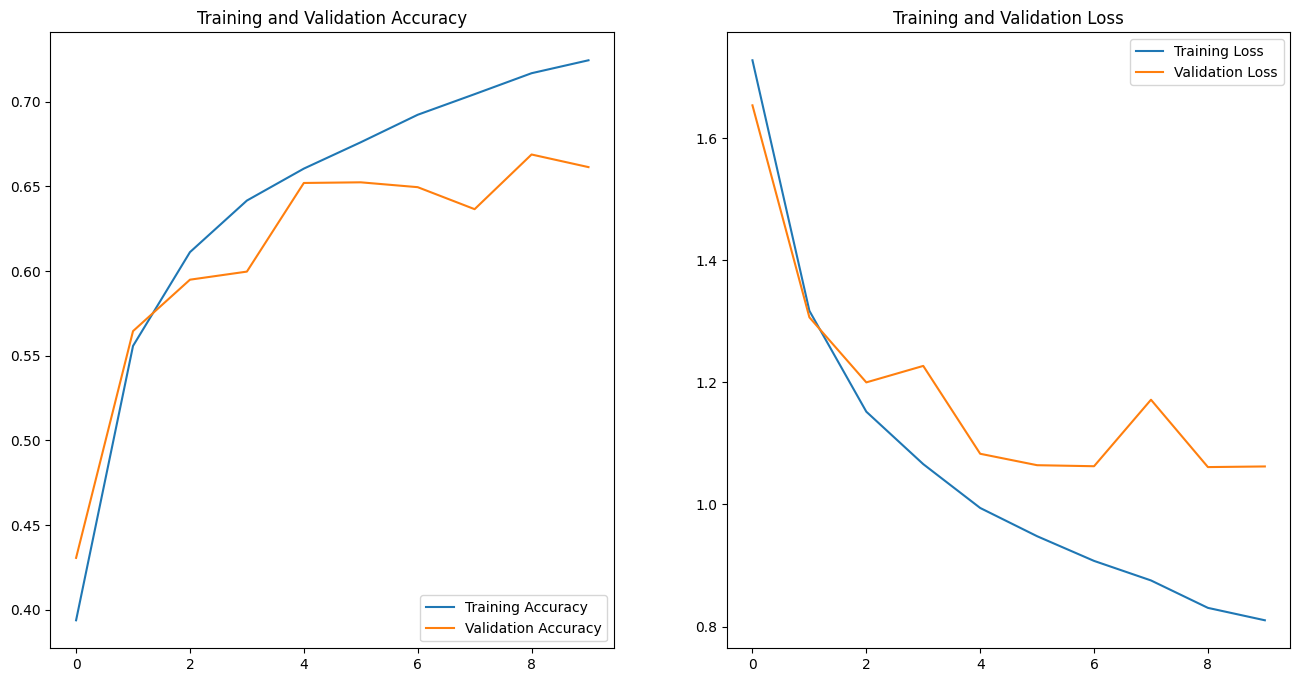

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()